El dataset 'hotel_reservations' contiene información sobre reservas de hotel.
El objetivo será predecir si una reserva tendrá más probabilidades de ser confirmada o cancelada, utilizando la variable booking_status como objetivo:

(1 => confirmada, 0 => cancelada).

COLUMNAS DATASET

<table>
    <tr>
        <td>Booking_ID</td>
        <td>Identificador único de cada reserva</td>
    </tr>
    <tr>
        <td>no_of_adults</td>
        <td>Número de adultos</td>
    </tr>
    <tr>
        <td>no_of_children</td>
        <td>Número de niños</td>
    </tr>
    <tr>
        <td>no_of_weekend_nights</td>
        <td>Número de noches de fin de semana (sábado o domingo) que el huésped se alojó o reservó en el hotel</td>
    </tr>
    <tr>
        <td>no_of_week_nights</td>
        <td>Número de noches entre semana (lunes a viernes) que el huésped se alojó o reservó en el hotel</td>
    </tr>
    <tr>
        <td>type_of_meal_plan</td>
        <td>Tipo de plan de comidas reservado por el cliente</td>
    </tr>
    <tr>
        <td>required_car_parking_space</td>
        <td>¿El cliente requiere un espacio de estacionamiento? (0 - No, 1 - Sí)</td>
    </tr>
    <tr>
        <td>room_type_reserved</td>
        <td>Tipo de habitación reservada por el cliente. Los valores están codificados por INN Hotels.</td>
    </tr>
    <tr>
        <td>lead_time</td>
        <td>Número de días entre la fecha de reserva y la fecha de llegada</td>
    </tr>
    <tr>
        <td>arrival_year</td>
        <td>Año de la fecha de llegada</td>
    </tr>
    <tr>
        <td>arrival_month</td>
        <td>Mes de la fecha de llegada</td>
    </tr>
    <tr>
        <td>arrival_date</td>
        <td>Día del mes de la fecha de llegada</td>
    </tr>
    <tr>
        <td>market_segment_type</td>
        <td>Designación del segmento de mercado</td>
    </tr>
    <tr>
        <td>repeated_guest</td>
        <td>¿Es el cliente un huésped recurrente? (0 - No, 1 - Sí)</td>
    </tr>
    <tr>
        <td>no_of_previous_cancellations</td>
        <td>Número de reservas previas canceladas por el cliente antes de la reserva actual</td>
    </tr>
    <tr>
        <td>no_of_previous_bookings_not_canceled</td>
        <td>Número de reservas previas no canceladas por el cliente antes de la reserva actual</td>
    </tr>
    <tr>
        <td>avg_price_per_room</td>
        <td>Precio promedio por día de la reserva; los precios de las habitaciones son dinámicos. (en euros)</td>
    </tr>
    <tr>
        <td>no_of_special_requests</td>
        <td>Número total de solicitudes especiales realizadas por el cliente (por ejemplo, piso alto, vista desde la habitación, etc.)</td>
    </tr>
    <tr>
        <td>booking_status</td>
        <td>Indicador que señala si la reserva fue cancelada o no</td>
    </tr>
</table>


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# cargo dataset
reservas = pd.read_csv('dataset/hotel_reservations.csv')

################### EDA ###################
# dimensiones dataset
print(f"# Dimensión dataset: {reservas.shape}")
print("#"*50)
# tipos de datos
print("# Columnas y tipos de datos:")
print(reservas.dtypes)
print("#"*50)
# verifico valores nulos en el dataset
nulos = reservas.isnull().sum()
if nulos.any():  # si hay al menos un valor nulo en alguna columna
    # filtro solo las columnas que tienen valores nulos
    nulos = nulos[nulos > 0]
    print("# Columnas con valores nulos y su cantidad:")
    print(nulos)
else:
    print("# No hay valores nulos en el dataset.")
print("#"*50)
# verifico si hay filas duplicadas utilizando Booking_ID
duplicados = reservas["Booking_ID"].duplicated().sum()
print(f"# Número de registros con Booking_ID duplicados: {duplicados}")
# si hay duplicados los elimino
if duplicados > 0:
    reservas = reservas.drop_duplicates(subset=["Booking_ID"], keep='first')
print("#"*50)
# elimino booking_ID porque no me sirve y màas adelante me daràa problemas con la normalización
reservas = reservas.drop(columns=["Booking_ID"]) 
# creo nueva columna 'trusted' para ver si el cliente es confiable o no
# inicializar la columna con -1 para los clientes no repetidos
reservas["trusted"] = -1  
# si el cliente es repetido y nunca ha cancelado, es confiable (1)
reservas["trusted"] = np.where(
    (reservas["repeated_guest"] == 1) & (reservas["no_of_previous_bookings_not_canceled"] > 0), 1, reservas["trusted"]
)
# si el cliente es repetido y ha cancelado antes, no es confiable (0)
reservas["trusted"] = np.where(
    (reservas["repeated_guest"] == 1) & (reservas["no_of_previous_cancellations"] > 0), 0, reservas["trusted"]
)
# total de noches reservadas
reservas["total_nights"] = reservas["no_of_weekend_nights"] + reservas["no_of_week_nights"]

print("# Estadísticas descriptivas:")
print(reservas.describe())
print("#"*50)

# Dimensión dataset: (36275, 19)
##################################################
# Columnas y tipos de datos:
Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status         

# Número de outliers en lead_time: 1331
# Número de outliers en avg_price_per_room: 1696
# Número de outliers en total_nights: 583


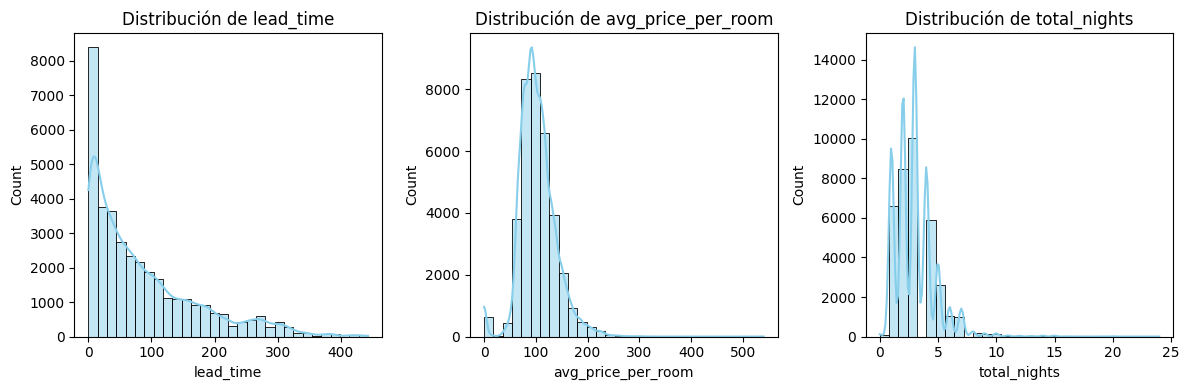

# Codificación de la variable 'booking_status':
{'Canceled': np.int64(0), 'Not_Canceled': np.int64(1)}
##################################################
# Nuevas columnas creadas con One-Hot Encoding:
['type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected', 'room_type_reserved_Room_Type 1', 'room_type_reserved_Room_Type 2', 'room_type_reserved_Room_Type 3', 'room_type_reserved_Room_Type 4', 'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6', 'room_type_reserved_Room_Type 7', 'market_segment_type_Aviation', 'market_segment_type_Complementary', 'market_segment_type_Corporate', 'market_segment_type_Offline', 'market_segment_type_Online']
##################################################
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
required_car_parking

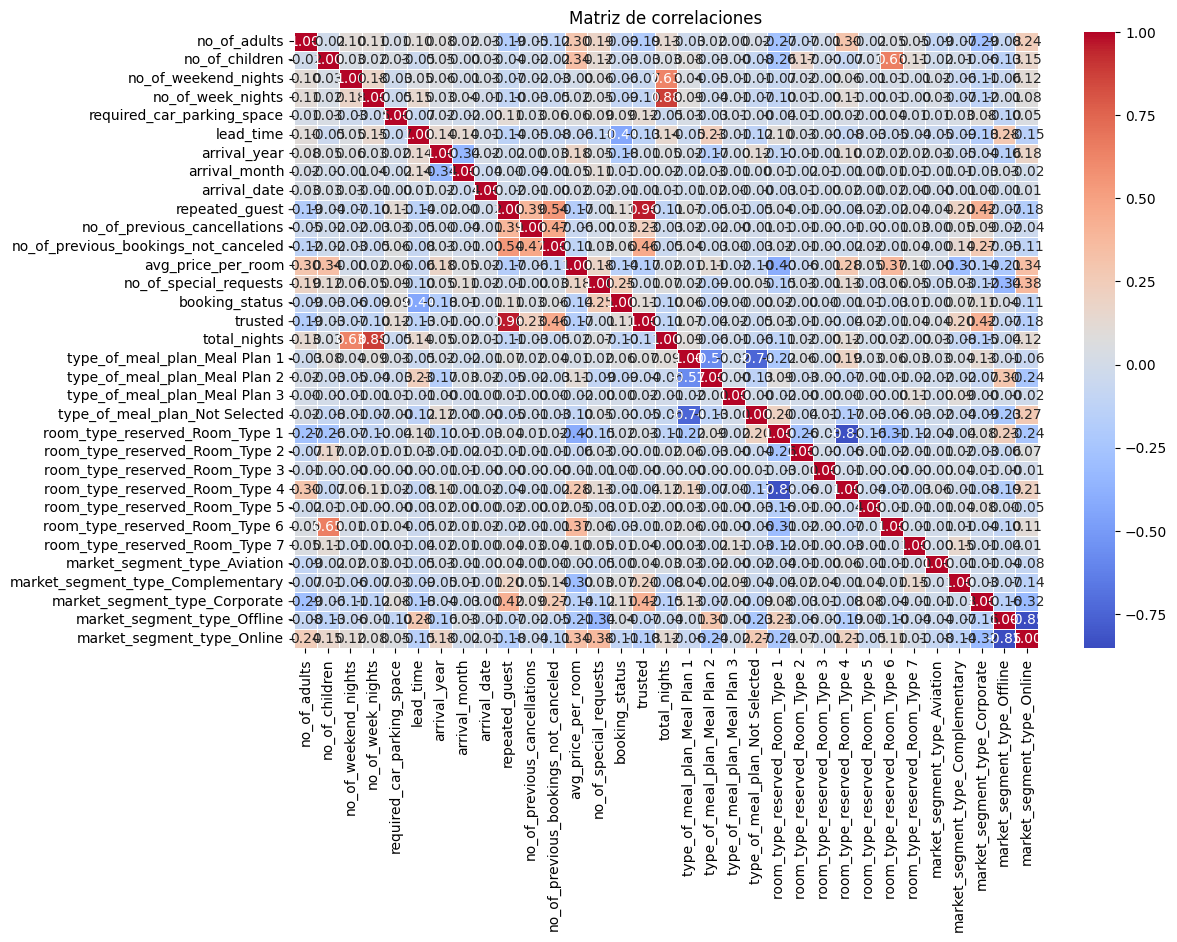

# Importancia de las características:
                          Caracteristica  Importancia
5                              lead_time     0.308688
12                    avg_price_per_room     0.151732
13                no_of_special_requests     0.105563
8                           arrival_date     0.092773
7                          arrival_month     0.080177
15                          total_nights     0.042043
3                      no_of_week_nights     0.037281
2                   no_of_weekend_nights     0.028112
31            market_segment_type_Online     0.023717
0                           no_of_adults     0.023491
6                           arrival_year     0.023418
30           market_segment_type_Offline     0.019431
16         type_of_meal_plan_Meal Plan 1     0.007916
17         type_of_meal_plan_Meal Plan 2     0.007868
1                         no_of_children     0.007140
20        room_type_reserved_Room_Type 1     0.006762
4             required_car_parking_space    

In [ ]:
# detección de outlier (son puntos que destacan mucho de la distribución general de los datos, pueden ser errores, casos excepcionales o valores extremos)
# identificación de outliers con el método IQR
def outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25) # primer cuartil -> es el valor del 25% de los datos
    Q3 = data[column].quantile(0.75) # tercer cuartil -> es el valor del 75% de los datos
    IQR = Q3 - Q1 # cuartil intermedio
    limite_inferior = Q1 - 1.5 * IQR # limite inferior para identificar outliers
    limite_superior = Q3 + 1.5 * IQR # limite superior para identificar outliers
    return data[(data[column] < limite_inferior) | (data[column] > limite_superior)]

# después de haber visto los valores extremos me quedo con los que tienen más sentido analizar
outliers_detected = {col: outliers_iqr(reservas, col) for col in ["lead_time", "avg_price_per_room", "total_nights"]}
for col, outliers in outliers_detected.items():
    print(f"# Número de outliers en {col}: {len(outliers)}")

plt.figure(figsize=(12, 4))
variables = ["lead_time", "avg_price_per_room", "total_nights"]
for i, col in enumerate(variables):
    plt.subplot(1, 3, i + 1)
    sns.histplot(reservas[col], bins=30, kde=True, color="skyblue")
    plt.title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

# eliminar outliers en variables relevantes
# reservas = reservas[reservas["lead_time"] <= 365]
# reservas = reservas[reservas["avg_price_per_room"] <= 300]
# al final he optado por no eliminarlos porque pueden ser relevantes, como el promedio del precio por noche alto podría ser de una habitación de lujo, entonces no se debería de eliminar. El outlier en el tiempo de reserva también lo he mantenido porque puede ser importante tenerlo, por ejemplo si una reserva se hace de un año para el otro podría ser un caso real, no necesariamente un error.

# codificación de variables categóricas
# Label Encoding para el target porque tiene un orden logíco (0 => cancelada, 1 => no cancelada)
encoder = LabelEncoder()
reservas["booking_status"] = encoder.fit_transform(reservas["booking_status"])

# One-Hot Encoding para las otras variables categóricas
reservas = pd.get_dummies(reservas, columns=["type_of_meal_plan", "room_type_reserved", "market_segment_type"])

print("# Codificación de la variable 'booking_status':")
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))
print("#"*50)

nuevas_columnas = [col for col in reservas.columns if col.startswith("type_of_meal_plan_") or col.startswith("room_type_reserved_") or col.startswith("market_segment_type_")]
print("# Nuevas columnas creadas con One-Hot Encoding:")
print(nuevas_columnas)
print("#"*50)

# verifico los tipos de dato nuevamente para asegurarnos que sean todos en formato númerico 
print(reservas.dtypes)

# para encontrar las variables más importantes para el objetivo booking_status
# quito variables redundantes que visualizo a continuación
# matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(reservas.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlaciones")
plt.show()

X = reservas.drop(columns=["booking_status"])  # excluyo el target
y = reservas["booking_status"]

# creo un modello Random Forest para evaluar la importancia de las caracteristicas
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X, y)

# creo un dataframe con la importancia de las caracteristicas
importancia = pd.DataFrame({"Caracteristica": X.columns, "Importancia": modelo.feature_importances_})
importancia = importancia.sort_values(by="Importancia", ascending=False)
print("# Importancia de las características:")
print(importancia)

# Caracteristicas seleccionadas: ['lead_time', 'avg_price_per_room', 'no_of_special_requests', 'arrival_date', 'arrival_month', 'total_nights', 'no_of_week_nights', 'no_of_weekend_nights', 'market_segment_type_Online', 'no_of_adults', 'arrival_year', 'market_segment_type_Offline']


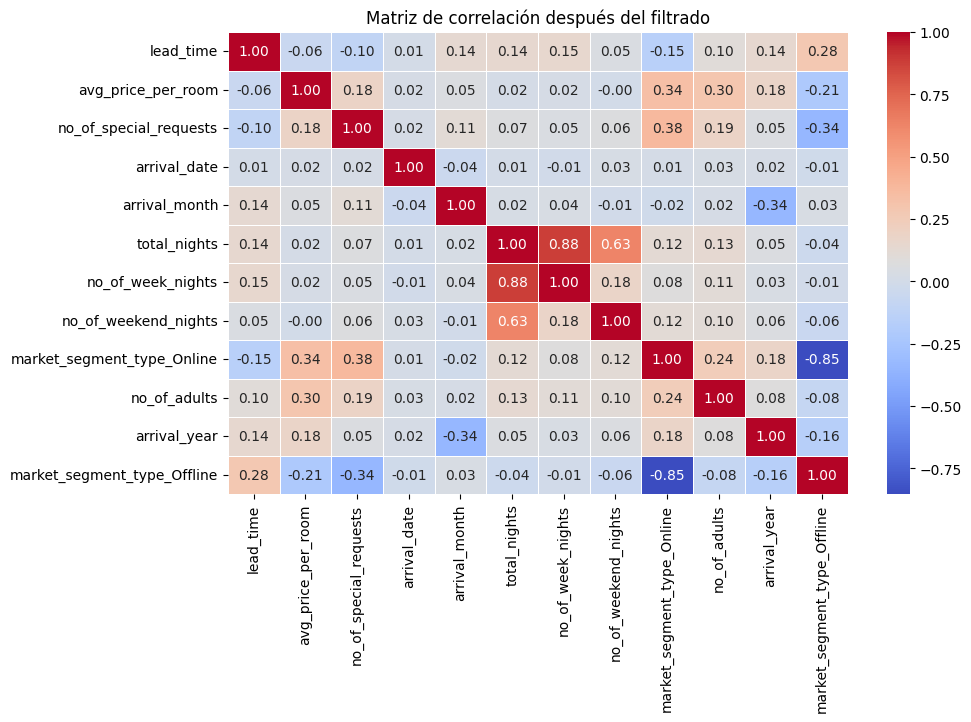

In [3]:
# filtro por las caracteristicas con importancia > 0.01
caracteristica_importantes = importancia[importancia["Importancia"] > 0.01]["Caracteristica"].tolist()
print("# Caracteristicas seleccionadas:", caracteristica_importantes)

# creamos un nuevo dataset solo con estas caracteristicas
X = reservas[caracteristica_importantes]
y = reservas["booking_status"]
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación después del filtrado")
plt.show()

Utilizo la regresión logística como modelo inicial porque es rápida, interpretable y eficaz en problemas de clasificación binaria como la predicción de cancelaciones de reservas. Su simplicidad permite entender la relación entre las variables y la variable objetivo, evitando el sobreajuste en las primeras fases del análisis. Además, actúa como línea base para comparar mejoras con modelos más complejos, asegurando que solo aumentemos la complejidad si es realmente necesario.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X = reservas.drop(columns=["booking_status", "total_nights"])  # quito el target y también total_nights (por redundancia)
y = reservas["booking_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#################### REGRESIÓN LOGÍSTICA #################### 
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

# metricas
print("# Accuracy:", accuracy_score(y_test, y_pred))
print("# Informe de clasificación:\n", classification_report(y_test, y_pred))


# Accuracy: 0.8124052377670572
# Informe de clasificación:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69      2377
           1       0.84      0.90      0.87      4878

    accuracy                           0.81      7255
   macro avg       0.79      0.77      0.78      7255
weighted avg       0.81      0.81      0.81      7255



Aquí busco los hiperparametros mejores a través de GridSearchCV. Esta es una técnica que permite probar diferentes combinaciones de hiperparametros sobre un modelo, evaluandolas con la validación cruzada (cros-validation).
Defino los hiperparametros en mi variable param_grid, entreno el modelo más veces para cada combinación psoible y utilizo la validación cruzada CV=5 para evaluar l'accurarcy de cada combinación.

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # regularización
    "solver": ["liblinear", "lbfgs"] # algoritmos posibles
}

# cv=5 -> cross-validation con 5 subconjuntos del dataset 
grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, cv=5, scoring="accuracy")
grid.fit(X_train_scaled, y_train)

print("# Mejor modelo:", grid.best_params_)
lr_optimo = grid.best_estimator_


# Mejor modelo: {'C': 1, 'solver': 'liblinear'}


# Accuracy: 0.8124052377670572
# Informe de clasificación:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69      2377
           1       0.84      0.90      0.87      4878

    accuracy                           0.81      7255
   macro avg       0.79      0.77      0.78      7255
weighted avg       0.81      0.81      0.81      7255



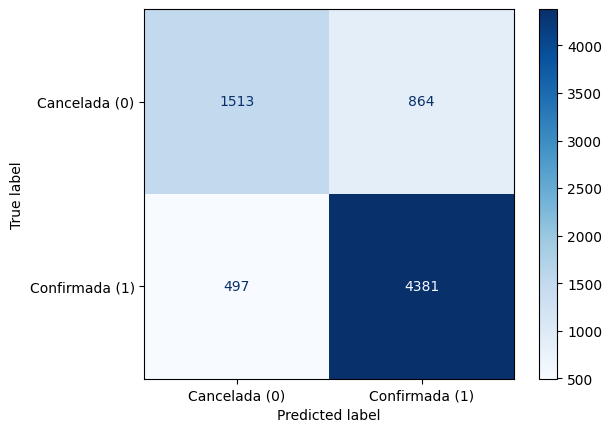

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# miro la matriz de confusíon para ver los resultados
y_pred = lr_optimo.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# nuevas metricas
print("# Accuracy:", accuracy_score(y_test, y_pred))
print("# Informe de clasificación:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancelada (0)", "Confirmada (1)"])
disp.plot(cmap="Blues")
plt.show()


Parece que el modelo no ha mejorado, posiblemente porque ya estaba optimizado en su versión inicial o porque los datos podrían mejorarse antes del entrenamiento. Voy a probar con otro modelo.
Utilizo Random Forest como segundo modelo porque es más flexible y potente que la regresión logística, permitiendo capturar relaciones no lineales y complejas en los datos. Además, es robusto al ruido y a valores atípicos, mejora la precisión sin requerir demasiada optimización y reduce el riesgo de overfitting gracias a la combinación de múltiples árboles.

In [7]:
#################### RANDOM FOREST #################### 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
print("# Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))
print("# Informe de clasificación:\n", classification_report(y_test, y_pred_rf))


# Accuracy Random Forest: 0.9070985527222605
# Informe de clasificación:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      2377
           1       0.92      0.95      0.93      4878

    accuracy                           0.91      7255
   macro avg       0.90      0.89      0.89      7255
weighted avg       0.91      0.91      0.91      7255



El modelo de random forest es mucho mejor para este dataset, así que voy a optimizar los hiperparametros con GridSearchCV

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],  # número arbóles
    "max_depth": [10, 30, 50, 100, None],  # maxima profundidad
    "min_samples_split": [2, 5, 10],  # minimo de muestars para dividir un nudo
    "min_samples_leaf": [1, 2, 4]  # minimo de muestars para una hoja
}

# n_jobs=-1 -> utiliza todos los nucleos disponibles del procesador (me ha tardado 9m30s en procesarse)
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("# Mejores hiperparametros:", grid_search.best_params_)

# utilizo el mejor modelo encontrado
rf_optimo = grid_search.best_estimator_


# Mejores hiperparametros: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


El AUC-ROC es una métrica de evaluación para modelos de clasificación, nos dice qué tan bien el modelo separa las clases (0 = cancelado y 1 = confirmado).
ROC (Receiver Operating Characteristic) -> Es una curva que muestra la relación entre la Tasa de Verdaderos Positivos (TPR / Recall) y la Tasa de Falsos Positivos (FPR) en diferentes umbrales de clasificación.
AUC (Area Under Curve) -> Es el área bajo la curva ROC, indicando qué tan bien el modelo separa las clases.

CALCULO DE PRESTACIONES Y OVERFITTING:

# AUC-ROC Training: 1.00
# AUC-ROC Test: 0.96

# Accuracy: 0.9083390764989663

# Report di classificazione:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      2377
           1       0.92      0.95      0.93      4878

    accuracy                           0.91      7255
   macro avg       0.90      0.89      0.89      7255
weighted avg       0.91      0.91      0.91      7255



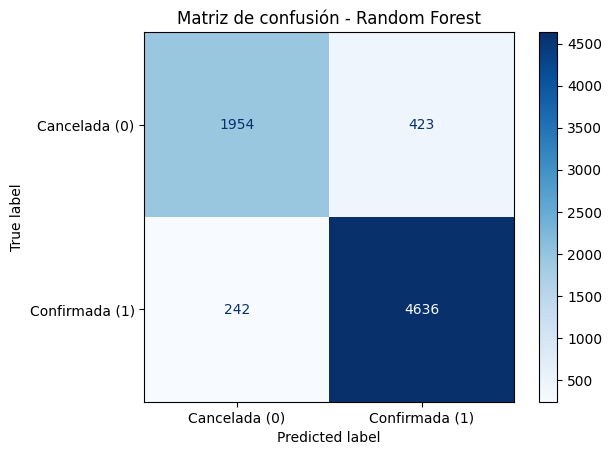

In [9]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# calculo de las probabilidades predecidas para la clase 1 
y_pred_prob_rf_train = rf_optimo.predict_proba(X_train_scaled)[:, 1]  # Training
y_pred_prob_rf_test = rf_optimo.predict_proba(X_test_scaled)[:, 1]  # Test

# calculo de AUC-ROC para Training y Test
train_auc = roc_auc_score(y_train, y_pred_prob_rf_train)
test_auc = roc_auc_score(y_test, y_pred_prob_rf_test)

print(f"# AUC-ROC Training: {train_auc:.2f}")
print(f"# AUC-ROC Test: {test_auc:.2f}")

y_pred = rf_optimo.predict(X_test_scaled)

# metricas
print("\n# Accuracy:", accuracy_score(y_test, y_pred))
print("\n# Report di classificazione:\n", classification_report(y_test, y_pred))

# matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancelada (0)", "Confirmada (1)"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Random Forest")
plt.show()



El modelo funciona bien pero tiene indicadores de ligero overfitting: 

AUC-ROC en training = 1.00 -> indica que el modelo predice perfectamente los datos de entrenamiento.

AUC-ROC en test = 0.96 -> aunque sigue siendo alto, es menor que en el training set.

La diferencia es de 0.04, lo cual indica ligero sobreajuste, pero no es extremo.
Si la diferencia fuera mayor a 0.10, sería una señal clara de overfitting.

# AUC-ROC Training: 0.96
# AUC-ROC Test: 0.94

# Accuracy: 0.8818745692625776

# Informe de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      2377
           1       0.92      0.91      0.91      4878

    accuracy                           0.88      7255
   macro avg       0.86      0.87      0.87      7255
weighted avg       0.88      0.88      0.88      7255



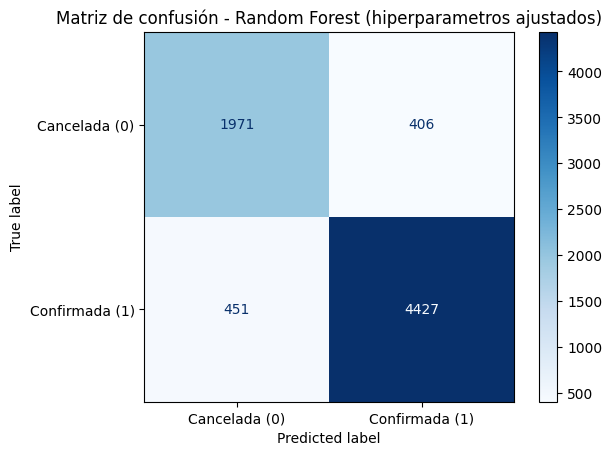

In [10]:
# creo nuevamente el modelo para disminuir el overfitting
rf_ajustado = RandomForestClassifier(
    n_estimators=100,
    max_depth=30,
    min_samples_leaf=10,
    min_samples_split=5,
    class_weight={0: 2, 1: 1},  # aumentamos la importancia de los erroes en la clase 0 (para disminuir los falsos positivos de resrevas canceladas)
    random_state=42
)

rf_ajustado.fit(X_train_scaled, y_train)

y_pred_rf = rf_ajustado.predict(X_test_scaled)
y_pred_prob_rf_train = rf_ajustado.predict_proba(X_train_scaled)[:, 1]
y_pred_prob_rf_test = rf_ajustado.predict_proba(X_test_scaled)[:, 1]

# metricas
train_auc = roc_auc_score(y_train, y_pred_prob_rf_train)
test_auc = roc_auc_score(y_test, y_pred_prob_rf_test)

print(f"# AUC-ROC Training: {train_auc:.2f}")
print(f"# AUC-ROC Test: {test_auc:.2f}")
print("\n# Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n# Informe de clasificación:\n", classification_report(y_test, y_pred_rf))

# matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancelada (0)", "Confirmada (1)"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Random Forest (hiperparametros ajustados)")
plt.show()

Ahora que ya tengo el modelo creo dos registros de prueba para predecir el resultado (1 reserva confirmada, 1 reserva cancelada)

In [11]:
# creo un diccionario con las variables del tarning
feature_names = X.columns

# creo el regsitro con los valores inicializados a 0
registro_prueba = pd.DataFrame(np.zeros((1, len(feature_names))), columns=feature_names)

# actualizo solo los campos relevantes
registro_prueba.loc[0, "lead_time"] = 45
registro_prueba.loc[0, "avg_price_per_room"] = 120
registro_prueba.loc[0, "no_of_special_requests"] = 2
registro_prueba.loc[0, "arrival_date"] = 15
registro_prueba.loc[0, "arrival_month"] = 7
registro_prueba.loc[0, "no_of_week_nights"] = 3
registro_prueba.loc[0, "no_of_weekend_nights"] = 2
registro_prueba.loc[0, "market_segment_type_Online"] = 1
registro_prueba.loc[0, "no_of_adults"] = 2
registro_prueba.loc[0, "arrival_year"] = 2018
registro_prueba.loc[0, "market_segment_type_Offline"] = 0

registro_prueba_scaled = scaler.transform(registro_prueba)

y_pred_prueba = rf_ajustado.predict(registro_prueba_scaled)
y_pred_prob = rf_ajustado.predict_proba(registro_prueba_scaled)

print(f"# Predicción reserva: {'Confirmada' if y_pred_prueba[0] == 1 else 'Cancelada'}")
print(f"# Probabilidad de confirmación: {y_pred_prob[0][1]:.2%}")
print(f"# Probabilidad de cancelación: {y_pred_prob[0][0]:.2%}")


# Predicción reserva: Confirmada
# Probabilidad de confirmación: 88.29%
# Probabilidad de cancelación: 11.71%


In [12]:
# creo otro caso de posible cancelación

registro_prueba_2 = pd.DataFrame(np.zeros((1, len(feature_names))), columns=feature_names)

registro_prueba_2.loc[0, "lead_time"] = 400
registro_prueba_2.loc[0, "avg_price_per_room"] = 500
registro_prueba_2.loc[0, "no_of_special_requests"] = 0
registro_prueba_2.loc[0, "arrival_date"] = 25
registro_prueba_2.loc[0, "arrival_month"] = 8
registro_prueba_2.loc[0, "no_of_week_nights"] = 8
registro_prueba_2.loc[0, "no_of_weekend_nights"] = 2
registro_prueba_2.loc[0, "market_segment_type_Online"] = 0
registro_prueba_2.loc[0, "market_segment_type_Offline"] = 1
registro_prueba_2.loc[0, "no_of_adults"] = 1
registro_prueba_2.loc[0, "arrival_year"] = 2025

registro_prueba_2_scaled = scaler.transform(registro_prueba_2)

y_pred_prueba_2 = rf_ajustado.predict(registro_prueba_2_scaled)
y_pred_prob_2 = rf_ajustado.predict_proba(registro_prueba_2_scaled)

print(f"# Predicción reserva: {'Confirmada' if y_pred_prueba_2[0] == 1 else 'Cancelada'}")
print(f"# Probabilidad de confirmación: {y_pred_prob_2[0][1]:.2%}")
print(f"# Probabilidad de cancelación: {y_pred_prob_2[0][0]:.2%}")


# Predicción reserva: Cancelada
# Probabilidad de confirmación: 33.78%
# Probabilidad de cancelación: 66.22%
